In [41]:
import pandas as pd
import numpy as np
from HanTa import HanoverTagger as ht
from tqdm.auto import tqdm
import top2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim
import pickle
import mgzip
from nltk.tokenize import sent_tokenize
from pandarallel import pandarallel
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import pyreadr
import textstat

pandarallel.initialize(progress_bar=True)
tqdm.pandas()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Feature engineering

In [2]:
# load command
with mgzip.open('../data/combined_news_pre.mgzip', 'rb') as handle:
    combined_news_pre = pickle.load(handle)

## Average sentence length

In [3]:
def avg_sent_len(input):
    sent_tokenize_list = sent_tokenize(input)
    return sum(len(x.split()) for x in sent_tokenize_list) / len(sent_tokenize_list)

In [4]:
def avg_sent(input):
    sent_tokenize_list = sent_tokenize(input)
    return len(sent_tokenize_list)

In [5]:
combined_news_pre['avg_length_sent'] = combined_news_pre['combined_text'].progress_apply(avg_sent)

  0%|          | 0/28432 [00:00<?, ?it/s]

In [6]:
combined_news_pre['avg_length'] = combined_news_pre['combined_text'].progress_apply(avg_sent_len)

  0%|          | 0/28432 [00:00<?, ?it/s]

## Presence of adjectives

In [7]:
tagger = ht.HanoverTagger('morphmodel_ger.pgz')

In [8]:
def pos_count(input):
    keywords_adj = ['ADJA', 'ADJD', 'ADV']
    keywords_noun = ['NN']
    count_adj = 0
    count_nn = 0
    count_total = 0
    for word in input:
        count_total += 1
        tag = tagger.analyze(word)[1]
        if tag in keywords_adj:
            count_adj += 1
        if tag in keywords_noun:
            count_nn += 1
    if count_total == 0:
        count_total = 1
    return count_adj, count_nn, count_adj/count_total, count_nn/count_total

In [9]:
combined_news_pre['pos_count'] = combined_news_pre['text_token'].parallel_apply(pos_count)

In [10]:
combined_news_pre[['count_adj', 'count_nn', 'percent_adj', 'percent_nn']] = pd.DataFrame(combined_news_pre['pos_count'].tolist(), index=combined_news_pre.index)

In [11]:
combined_news_pre.drop('pos_count', axis=1, inplace=True)

## Mention of scientist

In [12]:
def scientist_count(input):
    keywords = ['drosten', 'streeck', 'lauterbach', 'kekulé', 'schmidt-chanasit', 'wodarg']
    scientist = []
    for word in input:
        if word in keywords:
            scientist.append(word)
    return scientist

In [13]:
df_scientists = combined_news_pre['text_token'].apply(scientist_count).str.join('|').str.get_dummies()

In [14]:
combined_news_pre = pd.concat([combined_news_pre, df_scientists], axis=1)

## create doc2vecs

word2vec avg approach

In [15]:
# Load word2vec model (trained on an enormous Google corpus)
model = gensim.models.KeyedVectors.load_word2vec_format('/Users/richardkrauel/Downloads/45/model.bin', binary = True)

In [16]:
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word_list]
    if not doc:
        return np.nan
    return np.mean(model[doc], axis=0)

In [17]:
word_list = set(model.index_to_key)

In [18]:
def check_vocab(doc):
    return [word for word in doc if word in set(word_list)]

In [19]:
combined_news_pre['docvecs'] = combined_news_pre['text_token'].progress_apply(document_vector)

  0%|          | 0/28432 [00:00<?, ?it/s]

doc2vec approach (depends on training it on a big corpus)

In [35]:
tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(combined_news_pre['text_token'])]

In [38]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=40, dm=1)

In [42]:
model.build_vocab(tagged_data)

In [43]:
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [77]:
doc_ids = []
for doc_id in range(len(combined_news_pre)):
    doc_ids.append(list(model.dv[doc_id]))
combined_news_pre['docvecs'] = doc_ids

In [20]:
combined_news_pre[["vec" + str(int(x)) for x in np.linspace(start=0, stop=99, num=100)]] = combined_news_pre.docvecs.apply(pd.Series)

/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_6712/1941646934.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_news_pre[["vec" + str(int(x)) for x in np.linspace(start=0, stop=99, num=100)]] = combined_news_pre.docvecs.apply(pd.Series)
/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_6712/1941646934.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_news_pre[["vec" + str(int(x)) for x in np.linspace(start=0, stop=99, num=100)]] = combined_news_pre.docvecs.apply(pd.Series)
/var/folders

In [21]:
combined_news_pre.drop('docvecs', inplace=True, axis=1)

# Readability score

In [42]:
textstat.set_lang('de')

In [51]:
textstat.flesch_reading_ease(combined_news_pre['combined_text'][9453])

35.3

In [50]:
combined_news_pre['combined_text'][9453]

'Judith Vorrath ist Wissenschaftlerin in der Forschungsgruppe Sicherheitspolitik an der Stiftung Wissenschaft und Politik (SWP) und Wibke Hansen leitet den Bereich Analyse im Zentrum für internationale Friedenseinsätze (ZIF) Versagen die Vereinten Nationen (UN) in der COVID-19 Krise? Das wird mitunter in der aktuellen Debatte unterstellt. Doch dem liegen drei grundsätzliche Missverständnisse zugrunde: Erstens, dass es primär oder ausschließlich um eine Gesundheitskrise gehe; zweitens, dass die UN überwiegend untätig seien und drittens, das der UN-Sicherheitsrat in einer solchen Situation nicht gefragt sei. \xa0 Für die meisten Länder geht es nicht um eine Corona-Krise – sondern um die Bewältigung multipler, paralleler Krisen. Diese können neben Problemen bei der Gesundheitsversorgung ökonomischer, sozialer oder politischer Natur sein, sie können die Sicherheit betreffen und die humanitäre Lage.  Dabei lässt sich noch nicht absehen, wie diese verschiedenen Krisen aufeinanderfolgen oder 

In [52]:
def readability(input):
    if not input:
        return 0
    elif len(input) < 10:
        return 0
    return textstat.flesch_reading_ease(input)

In [53]:
combined_news_pre['readability'] = combined_news_pre['combined_text'].progress_apply(readability)

  0%|          | 0/28432 [00:00<?, ?it/s]

## Load topic modeling

In [55]:
# load precomputed model (learn_ngram OR learn_ngram_full), full uses original text, other one uses preprocessed texts
model = top2vec.Top2Vec.load('../models/topic2vec_learn_ngram.t2v')

In [56]:
model.hierarchical_topic_reduction(17)

[[105,
  19,
  126,
  44,
  111,
  158,
  265,
  124,
  185,
  213,
  132,
  244,
  161,
  57,
  72,
  59,
  245,
  187,
  148,
  228,
  246,
  109,
  171,
  117,
  137,
  62,
  130,
  173,
  26,
  206,
  192,
  217,
  266,
  135,
  210,
  144,
  67,
  220,
  69,
  46,
  227,
  81,
  190,
  254,
  243,
  83],
 [271,
  248,
  48,
  32,
  114,
  128,
  65,
  193,
  208,
  56,
  77,
  212,
  154,
  87,
  31,
  151,
  129,
  14,
  222,
  39,
  103,
  168,
  66,
  252,
  28,
  5],
 [202,
  267,
  189,
  269,
  85,
  272,
  209,
  17,
  200,
  257,
  255,
  104,
  95,
  123,
  195,
  249,
  99,
  37,
  116,
  153,
  13,
  34,
  188,
  152,
  175,
  247,
  40,
  15,
  233,
  268,
  42,
  30],
 [73,
  164,
  237,
  207,
  184,
  51,
  78,
  122,
  54,
  260,
  12,
  138,
  97,
  18,
  263,
  91,
  90,
  53,
  98,
  25,
  127,
  1],
 [218,
  22,
  182,
  236,
  112,
  75,
  234,
  160,
  259,
  251,
  230,
  176,
  139,
  258,
  8,
  199,
  60,
  55,
  93,
  88,
  134,
  147,
  68],
 [215, 145,

In [57]:
topic_nums, topic_score, topic_words, word_scores = model.get_documents_topics(list(combined_news_pre.index), reduced=True, num_topics=2)

In [58]:
combined_news_pre[['top2vec_0', 'top2vec_1']] = topic_nums

# Load sentiment predictions

In [87]:
# load command
with mgzip.open('../data/combined_comments_group.mgzip', 'rb') as handle:
    combined_comments_group = pickle.load(handle)

In [88]:
predict = pd.DataFrame()

In [89]:
predict = combined_news_pre

In [90]:
predict = predict.merge(combined_comments_group[['title', 'lexi_score', 'bert_score', 'vote_score', 'bert_label', 'count']], how = 'left', on = 'title')

In [91]:
predict['date'] = predict['date'].str.replace("-","")

In [92]:
predict.drop(['title', 'combined_text', 'text_token', 'combined_text_joined'], inplace=True, axis=1)

In [93]:
predict['date'] = predict['date'].str[:8]

In [94]:
with mgzip.open("../data/predict_raw.mgzip", 'wb') as f:
    pickle.dump(predict, f)

In [95]:
with mgzip.open("../data/predict_na.mgzip", 'wb') as f:
    pickle.dump(predict[predict['bert_score'].notna()], f)

In [96]:
predict.drop(['lexi_score', 'vote_score'], inplace=True, axis=1)

In [97]:
with mgzip.open("../data/predict_bert_topic.mgzip", 'wb') as f:
    pickle.dump(predict[predict['bert_score'].notna()], f)

In [98]:
predict.drop(['top2vec_0', 'top2vec_1'], inplace=True, axis=1)

In [99]:
with mgzip.open("../data/predict_bert_notopic.mgzip", 'wb') as f:
    pickle.dump(predict[predict['bert_score'].notna()], f)

# load the version we like to explore

In [246]:
with mgzip.open('../data/predict_bert_topic.mgzip', 'rb') as handle:
    predict = pickle.load(handle)

In [247]:
predict.to_csv('../data/predict_bert_topic.csv')

In [248]:
X = predict

In [249]:
X = X.dropna()

In [250]:
X[['tagespiegel', 'welt', 'zeit']] = pd.get_dummies(X['newspaper'])

/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_6712/2059504631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['tagespiegel', 'welt', 'zeit']] = pd.get_dummies(X['newspaper'])
/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_6712/2059504631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['tagespiegel', 'welt', 'zeit']] = pd.get_dummies(X['newspaper'])
/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_6712/2059504631.py:1: SettingWithCopyWarning: 
A value is tryin

In [251]:
X.drop('newspaper', inplace=True, axis=1)

/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_6712/1001060868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('newspaper', inplace=True, axis=1)


In [252]:
y = X['bert_label']

In [253]:
X.drop(['bert_score', 'bert_label'], axis=1, inplace=True)

/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_6712/958874841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['bert_score', 'bert_label'], axis=1, inplace=True)


In [254]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [138]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5 , cv = 3, verbose = 3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

rf_random.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.046 total time=  21.5s
[CV 1/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=0.049 total time= 2.8min


/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis_new/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.054 total time=  21.8s
[CV 2/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=0.064 total time= 2.8min
[CV 1/3] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=0.049 total time= 1.6min
[CV 3/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=0.059 total time= 2.8min
[CV 1/3] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600;, score=-0.783 total time=19.4min
[CV 2/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.058 total time=  21.2s
[CV 3/3] END bootstrap=False, max_depth=60, max_features=auto, min_samples

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

### Regressor

In [243]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.06330454354398718

In [214]:
regr = RandomForestRegressor(verbose=1, n_jobs=-1)
#regr = RandomForestRegressor(verbose = 1, n_jobs = -1, n_estimators = 600, min_samples_split = 10, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 90, bootstrap = False)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.08752252472209265

### Classifier

In [267]:
from sklearn.linear_model import LogisticRegressionCV
regr = LogisticRegressionCV()
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.5686298976790617

In [255]:
regr = RandomForestClassifier(verbose = 1, n_jobs = -1, n_estimators = 670, min_samples_split = 2, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 89, criterion = 'entropy')
regr.fit(X_train,y_train)
regr.score(X_test,y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 670 out of 670 | elapsed:   17.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 670 out of 670 | elapsed:    0.2s finished


0.6504866483653606

In [268]:
from sklearn.metrics import f1_score

f1_score(y_test, regr.predict(X_test), average='macro')

0.24166732956805345

In [106]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

scores = cross_val_score(XGBRegressor(), X, y)
scores.mean()

/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis_new/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis_new/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis_new/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/homebrew/Caskroom/miniforge/base/envs/NL

-0.025022174476943503

Neural network

In [148]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

In [238]:
regr = MLPRegressor(hidden_layer_sizes=(119),
                       max_iter = 3000,activation = 'tanh',
                       solver = 'adam', verbose=2)

In [239]:
regr.fit(X_train_norm, y_train)
regr.score(X_test_norm, y_test)

Iteration 1, loss = 0.04099641
Iteration 2, loss = 0.03529913
Iteration 3, loss = 0.03445408
Iteration 4, loss = 0.03461333
Iteration 5, loss = 0.03411104
Iteration 6, loss = 0.03403695
Iteration 7, loss = 0.03385303
Iteration 8, loss = 0.03377446
Iteration 9, loss = 0.03420975
Iteration 10, loss = 0.03335160
Iteration 11, loss = 0.03373337
Iteration 12, loss = 0.03323076
Iteration 13, loss = 0.03319121
Iteration 14, loss = 0.03315751
Iteration 15, loss = 0.03303683
Iteration 16, loss = 0.03319118
Iteration 17, loss = 0.03336568
Iteration 18, loss = 0.03308832
Iteration 19, loss = 0.03283949
Iteration 20, loss = 0.03292058
Iteration 21, loss = 0.03299709
Iteration 22, loss = 0.03271226
Iteration 23, loss = 0.03280557
Iteration 24, loss = 0.03273414
Iteration 25, loss = 0.03294693
Iteration 26, loss = 0.03280608
Iteration 27, loss = 0.03256496
Iteration 28, loss = 0.03234007
Iteration 29, loss = 0.03279350
Iteration 30, loss = 0.03249393
Iteration 31, loss = 0.03260353
Iteration 32, los

0.0606465662762381

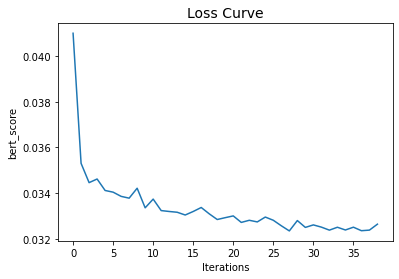

In [240]:
import matplotlib.pyplot as plt
plt.plot(regr.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('bert_score')
plt.show()

In [244]:
y_pred = regr.predict(X_test)

In [245]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 0.17404903048763853


In [260]:
regr = MLPClassifier(verbose = 1, max_iter=3000)

In [261]:
regr.fit(X_train_norm, y_train)
regr.score(X_test_norm, y_test)

Iteration 1, loss = 0.76727051
Iteration 2, loss = 0.73334017
Iteration 3, loss = 0.72331130
Iteration 4, loss = 0.71739228
Iteration 5, loss = 0.71462353
Iteration 6, loss = 0.70912208
Iteration 7, loss = 0.70628967
Iteration 8, loss = 0.70204123
Iteration 9, loss = 0.70097612
Iteration 10, loss = 0.69964683
Iteration 11, loss = 0.69648761
Iteration 12, loss = 0.69579957
Iteration 13, loss = 0.69291822
Iteration 14, loss = 0.69267798
Iteration 15, loss = 0.69230002
Iteration 16, loss = 0.69542101
Iteration 17, loss = 0.69324232
Iteration 18, loss = 0.68920576
Iteration 19, loss = 0.68788890
Iteration 20, loss = 0.68801432
Iteration 21, loss = 0.68670658
Iteration 22, loss = 0.68799134
Iteration 23, loss = 0.68663865
Iteration 24, loss = 0.68737110
Iteration 25, loss = 0.68899428
Iteration 26, loss = 0.68567787
Iteration 27, loss = 0.68421456
Iteration 28, loss = 0.68487069
Iteration 29, loss = 0.68807349
Iteration 30, loss = 0.68301321
Iteration 31, loss = 0.68316565
Iteration 32, los

0.6350137259795358

In [264]:
from sklearn.metrics import f1_score

f1_score(y_test, regr.predict(X_test_norm), average='macro')

0.39455546308508493

## Construct data set for regression and figures

### Add corona control variables

In [191]:
owid_covid_data = pd.read_csv('../data/owid-covid-data.csv', low_memory=False)

In [192]:
owid_covid_data = owid_covid_data[(owid_covid_data['location'] == 'Germany') & (owid_covid_data['date'] <= '2021-12-31')]

In [193]:
owid_covid_data = owid_covid_data[['date', 'new_cases_smoothed', 'new_deaths_smoothed', 'icu_patients', 'new_tests_smoothed', 'new_vaccinations_smoothed', 'stringency_index']]

In [194]:
owid_covid_data['date'] = owid_covid_data['date'].str.replace("-","")

In [195]:
predict = predict.merge(owid_covid_data, on='date', how='left')

In [199]:
predict_small = predict[['date', 'bert_score', 'bert_label', 'count','newspaper', 'top2vec_0', 'top2vec_1', 'drosten', 'kekulé', 'lauterbach', 'streeck', 'wodarg', 'avg_length', 'count_nn', 'count_adj', 'percent_adj', 'percent_nn', 'new_cases_smoothed', 'new_deaths_smoothed', 'icu_patients', 'new_tests_smoothed', 'new_vaccinations_smoothed', 'stringency_index', 'readability']]

In [171]:
predict_small[['bert_score', 'bert_label', 'count']] = predict[['bert_score', 'bert_label', 'count']]

/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_6712/4122837508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_small[['bert_score', 'bert_label', 'count']] = predict[['bert_score', 'bert_label', 'count']]
/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_6712/4122837508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_small[['bert_score', 'bert_label', 'count']] = predict[['bert_score', 'bert_label', 'count']]
/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipyke

In [200]:
predict_small

,date,bert_score,bert_label,count,newspaper,top2vec_0,top2vec_1,drosten,kekulé,lauterbach,...,count_adj,percent_adj,percent_nn,new_cases_smoothed,new_deaths_smoothed,icu_patients,new_tests_smoothed,new_vaccinations_smoothed,stringency_index,readability
0,20211130,-0.534319,negative,16.0,zeit,11,7,0,0,0,...,99,0.159420,0.495974,57986.0,273.000,4642.0,278909.0,762747.0,63.89,67.55
1,20211130,-0.144371,negative,26.0,zeit,1,7,0,0,0,...,57,0.182692,0.567308,57986.0,273.000,4642.0,278909.0,762747.0,63.89,40.35
2,20211130,-0.370915,neutral,80.0,zeit,16,15,0,0,0,...,62,0.185075,0.405970,57986.0,273.000,4642.0,278909.0,762747.0,63.89,51.20
3,20211130,-0.469456,negative,89.0,zeit,3,13,0,0,0,...,37,0.171296,0.546296,57986.0,273.000,4642.0,278909.0,762747.0,63.89,33.60
4,20211129,-0.436324,neutral,37.0,zeit,6,15,0,0,0,...,25,0.154321,0.592593,57925.0,261.714,4605.0,278953.0,735399.0,63.89,39.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24280,20200120,-0.992965,negative,1.0,tagespiegel,1,11,0,0,0,...,39,0.170306,0.480349,NaN,NaN,NaN,NaN,NaN,NaN,53.65
24281,20200120,0.045299,neutral,1.0,tagespiegel,10,8,0,0,0,...,46,0.183267,0.529880,NaN,NaN,NaN,NaN,NaN,NaN,49.30
24282,20200119,-0.059480,neutral,2.0,tagespiegel,6,12,0,0,0,...,50,0.145349,0.508721,NaN,NaN,NaN,NaN,NaN,NaN,52.85
24283,20200109,-0.893052,negative,1.0,tagespiegel,14,3,0,0,0,...,46,0.159722,0.513889,NaN,NaN,NaN,NaN,NaN,NaN,41.75


In [201]:
pyreadr.write_rdata("../data/predict_small.RData", predict_small, df_name="predict")

In [202]:
predict_small.to_csv("../data/predict_small.csv")